In [1]:
import os
import pickle
import numpy as np
from pydrake.all import (#PiecewisePolynomial, 
                        #InverseKinematics, 
                        HPolyhedron,
                        Sphere, 
                        Cylinder,
                        Rgba, 
                        RigidTransform, 
                        RotationMatrix, 
                        #IrisInConfigurationSpace, 
                        RollPitchYaw,
                        StartMeshcat,
                        MeshcatVisualizerParams,
                        MeshcatVisualizer,
                        Role,
                        TriangleSurfaceMesh,
                        SurfaceTriangle,
                        IrisOptions
                        )
from functools import partial
import numpy as np
from pydrake.planning import RobotDiagramBuilder
from pydrake.all import SceneGraphCollisionChecker
from region_generation import SNOPT_IRIS_obstacles_simple
from visibility_utils import (get_col_func, 
                              get_sample_cfree_handle,
                              get_coverage_estimator,
                              point_in_regions
                              )
from visibility_seeding import VisSeeder
from visibility_logging import Logger
from scipy.sparse import lil_matrix
from tqdm import tqdm
from ur3e_demo import UrDiagram, SetDiffuse
import pydrake



/home/peter/.local/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.17.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

add_shelf = True
seed = 1
np.random.seed(seed)

ur = UrDiagram(num_ur = 1, weld_wrist = True, add_shelf = add_shelf,
                 add_gripper = True)
meshcat = ur.meshcat
plant = ur.plant
diagram_context = ur.diagram.CreateDefaultContext()
ur.diagram.ForcedPublish(diagram_context)
diagram = ur.diagram

plant_context = ur.plant.GetMyMutableContextFromRoot(
        diagram_context)
scene_graph_context = ur.scene_graph.GetMyMutableContextFromRoot(
    diagram_context)
inspector = ur.scene_graph.model_inspector()    
robot_instances = [plant.GetModelInstanceByName("ur0"), plant.GetModelInstanceByName("schunk0")]
step_size = 0.125
checker = SceneGraphCollisionChecker(model = diagram.Clone(), 
                robot_model_instances = robot_instances,
                distance_function_weights =  [1] * plant.num_positions(),
                #configuration_distance_function = _configuration_distance,
                edge_step_size = step_size)

scaler = 1 #np.array([0.8, 1., 0.8, 1, 0.8, 1, 0.8]) 
q_min = ur.plant.GetPositionLowerLimits()*scaler
q_max =  ur.plant.GetPositionUpperLimits()*scaler

col_func_handle_ = get_col_func(plant, plant_context)
sample_cfree = get_sample_cfree_handle(q_min,q_max, col_func_handle_)
estimate_coverage = get_coverage_estimator(sample_cfree, pts = 5000)

INFO:drake:Meshcat listening for connections at http://localhost:7002
INFO:drake:Allocating contexts to support 20 parallel queries given omp_num_threads 20 omp_max_threads 20 and omp_thread_limit 2147483647 OpenMP enabled in build? true


http://localhost:7002


In [3]:
query = ur.scene_graph.get_query_output_port().Eval(ur.scene_graph.GetMyContextFromRoot(diagram_context))
inspector = query.inspector()
a = inspector.GetCollisionCandidates()
geomids= []
for b, c in a:
    geomids.append(b)
    geomids.append(c)
ids = list(set(inspector.GetAllGeometryIds()))
frame_id_dict = {}
for idx in range(len(ids)):
    #print(idx, plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])))
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='body':
        frame_id_dict['body'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='left_finger':
        frame_id_dict['left_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='right_finger':
        frame_id_dict['right_finger'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_3_link':
        frame_id_dict['ur_wrist_3_link'] = ids[idx]
    if ur.plant.GetBodyFromFrameId(inspector.GetFrameId(ids[idx])).name() =='ur_wrist_2_link':
        frame_id_dict['ur_wrist_2_link'] = ids[idx]

print(frame_id_dict)
geom_ids = [inspector.GetGeometries(inspector.GetFrameId(frame_id_dict[k]))[0] for k in ['ur_wrist_2_link','ur_wrist_3_link','body', 'left_finger', 'right_finger']]

sh_frames = [6,7, 11,12,13]
sh_geom = [inspector.GetShape(id) for id in geom_ids] 
sh_names = ['ur_wrist_2_link','ur_wrist_3_link', 'box', 'l','r']

def plot_endeff_pose(q2, name = '', color = Rgba(1,1,0.1,0.8)):
    ur.plant.SetPositions(plant_context, q2.reshape(-1,1))
    tfs = [ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(fr))) for fr in sh_frames]
    for n, f, geom in zip(sh_names[2:], tfs[2:], sh_geom[2:]):
        #print(n,f,geom)
        ur.meshcat.SetObject("/iris/shunk/"+name+"/"+n,
                                geom,
                                color)
        ur.meshcat.SetTransform("/iris/shunk/"+name+"/"+n, f)
# for i,p in enumerate(poi):
#     plot_endeff_pose(p, str(i))
def densify_waypoints(waypoints_q):
    densify = 200
    dists = []
    dense_waypoints = []
    for idx in range(len(waypoints_q[:-1])):
        a = waypoints_q[idx]
        b = waypoints_q[idx+1]
        t = np.linspace(1,0, 10)
        locs_endeff = []
        dists_endeff = []
        for tval in t:
            a = a*tval + b*(1-tval)
            qa = a#Ratfk.ComputeQValue(ta, np.zeros(7))
            #showres(qa)
            #time.sleep(0.1)            
            ur.plant.SetPositions(plant_context, qa)
            tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
            tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
            locs_endeff.append(tf)
        for i in range(len(locs_endeff)-1):
            dists_endeff.append(np.linalg.norm(locs_endeff[i]- locs_endeff[i+1]))
        d = np.sum(dists_endeff)
        #print(d * densify)
        t = np.linspace(1,0,int(densify*d))
        for tval in t:
            dense_waypoints.append(waypoints_q[idx]*tval + waypoints_q[idx+1]*(1-tval))
    return dense_waypoints

def plot_endeff_traj(dense_waypoints):
    color = Rgba(1,0,0,1.0)
    start_idx = 0
    for i, qa in enumerate(dense_waypoints):
        #qa = Ratfk.ComputeQValue(ta, np.zeros(7))
        #showres(qa)
        #time.sleep(0.1)            
        ur.plant.SetPositions(plant_context, qa)
        tf_tot= ur.plant.EvalBodyPoseInWorld(plant_context, ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11)))
        tf = tf_tot.translation() + tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15

        ur.meshcat.SetObject(f"/iris/points/traj/{i+start_idx}",
                               Sphere(0.005),
                               color)

        ur.meshcat.SetTransform(f"/iris/points/traj/{i+start_idx}",
                                   RigidTransform(RotationMatrix(),
                                                  tf))

def showres(qvis):
    col_shunk_col =  Rgba(0.8, 0.0, 0, 0.5)    
    col_shunk_free =  Rgba(0.0, 0.8, 0.5, 0.5) 
    ur.plant.SetPositions(plant_context, qvis)
    col = col_func_handle_(qvis)
    shunk = ur.plant.get_body(pydrake.multibody.tree.BodyIndex(11))
    tf_tot = shunk.EvalPoseInWorld(plant_context)
    tf = tf_tot.translation()
    
   # tf_tot= plant.EvalBodyPoseInWorld(plant_context, plant.get_body(pydrake.multibody.tree.BodyIndex(7)))
    #tf = tf_tot.translation() - tf_tot.GetAsMatrix4()[:3,:3][:,1] *0.15
    if col:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_col)
    else:
        ur.meshcat.SetObject(f"/drake/visualizer/shunk",
                                   Sphere(0.05),
                                   col_shunk_free)
    ur.meshcat.SetTransform(f"/drake/visualizer/shunk",
                                   RigidTransform(RotationMatrix(),
                                                  tf))
    
    ur.diagram.ForcedPublish(diagram_context)

{'ur_wrist_2_link': <GeometryId value=66>, 'ur_wrist_3_link': <GeometryId value=70>, 'body': <GeometryId value=79>, 'left_finger': <GeometryId value=85>, 'right_finger': <GeometryId value=91>}


In [17]:
import pickle
import os

exp_name = "experiment_5dof_ur_shelf_0_1000_0.050redu20230819090919"#"5dof_ur_naive_shelf_20230819090833_1_1_0.050_0.100" #"experiment_5dof_ur_shelf_0_1000_0.100redu20230818072135"#"5DOf_ur_20230703162006_12_1000_0.050_0.140"
# poly_names = os.listdir("logs/"+exp_name+"/regions")
data_chkpts = os.listdir("logs/"+exp_name+"/data")
# poly_names.sort()
itmax = np.max([int(x.replace('it_', '').replace('.pkl','')) for x in data_chkpts])
regions = []
# for p in poly_names:
#     with open("logs/"+exp_name+"/regions/"+p, 'rb') as f:
#         d = pickle.load(f)
#     regions.append(HPolyhedron(d['ra'], d['rb']))

with open("logs/"+exp_name+"/data/"+f"it_{itmax}.pkl", 'rb') as f:
    d2 = pickle.load(f)

seed_points = d2['sp'][-1]
for rga, rgb in zip(d2['ra'], d2['rb']):
    for a,b in zip(rga, rgb):
        regions.append(HPolyhedron(a,b))


poi = []
poi.append(np.array([-0.34743, -0.92743,  0.47257,  0.02257, -0.02743]))
poi.append(np.array([-1.62743, -1.32743,  2.57257, -1.22743, -0.02743]))
poi.append(np.array([-1.62743, -2.02743,  1.67257,  0.37257, -0.02743]))
poi.append(np.array([-1.72743, -1.82743, -2.02743,  0.67257, -0.02743]))
poi.append(np.array([-1.72743, -1.92743,  1.07257, -2.32743, -0.02743]))
poi.append(np.array([-1.72743, -1.32743, -0.92743, -1.02743, -0.02743]))
poi.append(np.array([-1.52743, -2.42743,  0.87257, -1.62743, -0.02743]))
poi.append(np.array([-2.12743, -0.52743, -1.92743,  2.47257, -1.02743]))
snopt_iris_options = IrisOptions()
snopt_iris_options.require_sample_point_is_contained = True
snopt_iris_options.iteration_limit = 10
snopt_iris_options.configuration_space_margin = 1.0e-3
#snopt_iris_options.max_faces_per_collision_pair = 60
snopt_iris_options.termination_threshold = -1
#snopt_iris_options.q_star = np.zeros(3)
snopt_iris_options.num_collision_infeasible_samples = 19
snopt_iris_options.relative_termination_threshold = 0.02
iris_handle = partial(SNOPT_IRIS_obstacles_simple, 
                      region_obstacles = [],
                      plant = plant, 
                      context = diagram_context,
                      snoptiris_options = snopt_iris_options,
                     )

#regions_poi=iris_handle(poi)
# with open('rpoi_shelf.pkl', 'wb') as f:
#     ra = [r.A() for r in regions_poi]
#     rb = [r.b() for r in regions_poi]
#     pickle.dump([ra, rb], f)
with open('rpoi_shelf.pkl', 'rb') as f:
    d = pickle.load(f)
    regions_poi = [HPolyhedron(a,b) for a,b in zip(d[0], d[1])]

In [18]:
len(regions)

435

In [19]:
vols = [r.MaximumVolumeInscribedEllipsoid().Volume() for r in regions]

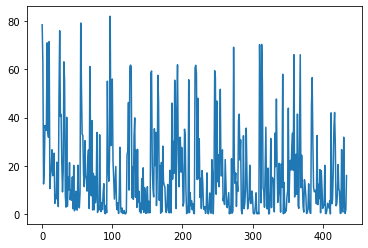

In [20]:
import matplotlib.pyplot as plt
plt.plot(vols)

In [22]:
d2.keys()

dict_keys(['vg', 'vad', 'sp', 'ra', 'rb', 'tstep', 'tsample', 'tccv', 'ttotal'])

Text(0.5, 1.0, 'connectivity')

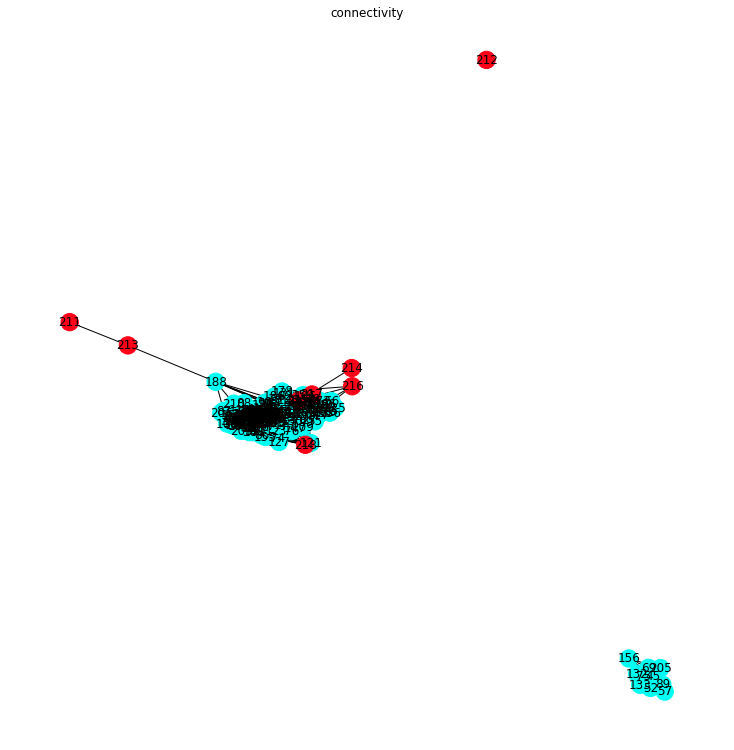

In [14]:
import networkx as nx

from visibility_utils import generate_distinct_colors

regs = regions+regions_poi
connectivity_graph = nx.Graph()
for idx in range(len(regs)):
    connectivity_graph.add_node(idx)


for idx1 in range(len(regs)):
    for idx2 in range(idx1 +1, len(regs)):
        r1 = regs[idx1]
        r2 = regs[idx2]
        if r1.IntersectsWith(r2):
            connectivity_graph.add_edge(idx1,idx2)

largest_con_comp = list(list(nx.connected_components(connectivity_graph))[0])
regions_connected_component = [regs[i] for i in largest_con_comp]

fig = plt.figure(figsize=(10,10))
hues = generate_distinct_colors(2+1)[1:]
colors = []
for g, h in zip([regions, regions_poi], hues):
    colors += [h]*len(g)

nx.draw_spring(connectivity_graph, 
                with_labels = True, 
                node_color = colors)
plt.title(f"connectivity")

In [15]:
def conversion_dummy(q):
    return q
import dijkstraspp
dspp = dijkstraspp.DijkstraSPPsolver(regions_connected_component, conversion_dummy)
# import pickle
# with open(exp_name+"_dspp.pkl", 'rb') as f:
#     dspp = pickle.load(f)

[DijkstraSPP] Pre-Building adjacency matrix  0 / 208
[DijkstraSPP] Pre-Building adjacency matrix  10 / 208
[DijkstraSPP] Pre-Building adjacency matrix  20 / 208
[DijkstraSPP] Pre-Building adjacency matrix  30 / 208
[DijkstraSPP] Pre-Building adjacency matrix  40 / 208
[DijkstraSPP] Pre-Building adjacency matrix  50 / 208
[DijkstraSPP] Pre-Building adjacency matrix  60 / 208
[DijkstraSPP] Pre-Building adjacency matrix  70 / 208
[DijkstraSPP] Pre-Building adjacency matrix  80 / 208
[DijkstraSPP] Pre-Building adjacency matrix  90 / 208
[DijkstraSPP] Pre-Building adjacency matrix  100 / 208
[DijkstraSPP] Pre-Building adjacency matrix  110 / 208
[DijkstraSPP] Pre-Building adjacency matrix  120 / 208
[DijkstraSPP] Pre-Building adjacency matrix  130 / 208
[DijkstraSPP] Pre-Building adjacency matrix  140 / 208
[DijkstraSPP] Pre-Building adjacency matrix  150 / 208
[DijkstraSPP] Pre-Building adjacency matrix  160 / 208
[DijkstraSPP] Pre-Building adjacency matrix  170 / 208
[DijkstraSPP] Pre-Bui

In [17]:
import pickle
dsppname = exp_name+"_dspp.pkl"
with open(dsppname, 'wb') as f:
    pickle.dump(dspp, f)

Text(0.5, 1.0, 'connectivity')

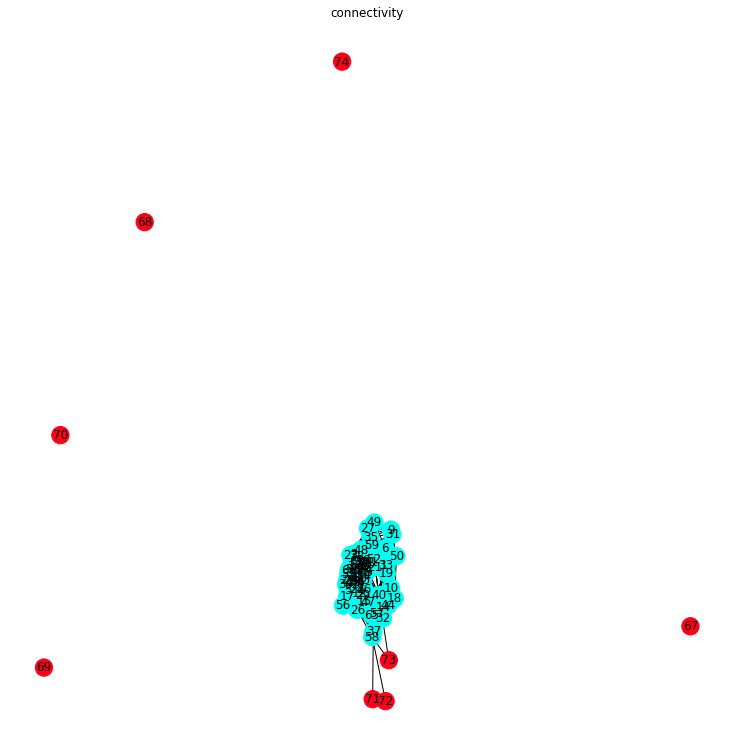

In [10]:
for p in poi:
    print(point_in_regions(p, regions_connected_components+regions_poi))

True
True
True
True
True
True
True
True


In [19]:
import time
centers = [r.ChebyshevCenter() for r in regions]
start = centers[0]
for _ in range(50):
    #nxt = vs.sample_in_regions() #
    while True:
        nxt = poi[np.random.choice(len(poi))] #sample_cfree(1, 1000, [])[0].reshape(-1,1)#
        plot_endeff_pose(nxt, str(0))
        if nxt.squeeze()[0] != start.squeeze()[0]:
            break
    wp, dist = dspp.solve(start, nxt, refine_path=True)#dijkstra_spp(start, nxt, node_intersections, base_ad_mat, vs.regions, point_conversion, optimize= True)
    print(dist)
    if dist >0:
        dense_waypoints = densify_waypoints(wp)
        plot_endeff_traj(dense_waypoints)
        for qa in dense_waypoints:
            #qa = #Ratfk.ComputeQValue(ta, np.zeros(3))
            showres(qa)
            if col_func_handle_(qa):
                print('col')
                #break
            time.sleep(0.01)
        start = nxt
        time.sleep(0.01)
        ur.meshcat.Delete("/iris/points/traj/")
        
    else:
        nxt = centers[np.random.choice(len(centers))]

[DijkstraSPP] optimized distance/ start-distance = 7.85 / 9.27 = 0.85
7.849117013042893
col
col
col
col
col
col
col
col
col
[DijkstraSPP] Points not in set, idxs [201] ,  []
[DijkstraSPP] Points not in regions
-1
[DijkstraSPP] optimized distance/ start-distance = 7.98 / 11.21 = 0.71
7.976378783952458
col
col
col
col
col
col
col
col
col
[DijkstraSPP] optimized distance/ start-distance = 4.79 / 7.15 = 0.67
4.792227046719747
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
[DijkstraSPP] optimized distance/ start-distance = 7.39 / 9.75 = 0.76
7.385262643750286
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
[DijkstraSPP] optimized distance/ start-distance = 7.39 / 9.75 = 0.76
7.385262643997481
col
col
col
col
col
col
col
col
col
col
col
col
col
col
col
co

KeyboardInterrupt: 

In [23]:
poi[0]

array([-0.31743, -0.92743,  0.47257,  0.07257, -0.02743])

In [29]:
nxt = sample_cfree(1, 1000, [])[0]#centers[np.random.choice(len(centers))]
plot_endeff_pose(nxt, str(0))

TypeError: SetPositions(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.multibody.plant.MultibodyPlant, context: pydrake.systems.framework.Context, q: numpy.ndarray[numpy.float64[m, 1]]) -> None
    2. (self: pydrake.multibody.plant.MultibodyPlant, context: pydrake.systems.framework.Context, model_instance: pydrake.multibody.tree.ModelInstanceIndex, q: numpy.ndarray[numpy.float64[m, 1]]) -> None

Invoked with: <pydrake.multibody.plant.MultibodyPlant object at 0x7f0b83fcba70>, <pydrake.systems.framework.LeafContext object at 0x7f0bea6239f0>, array([[-2.5256753 ,  0.41912518, -1.99770284,  0.50501091,  1.12960691]])

In [43]:
plant

In [48]:
plant.SetPositions( plant_context, nxt.reshape(-1,1))

In [42]:
plant.Clone()

In [38]:
ur.plant.GetMyMutableContextFromRoot(diagram_context)